# Laplacian Associative Memory (LAM) - DEV 23

[Multiscale representations of community structures in attractor neural networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8412329/pdf/pcbi.1009296.pdf) (2021)

- _set_state Function
- Sigma Distribution
- Latex

In [1]:
from nn import LAM
import libtools

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

---

#### LOAD DATA

In [3]:
src = np.load('../data/mat/SOM_orient_v1.npy')

print('Map:', src.shape)
print('Theta θ | min:', round(src.min(),4), 'max:', round(src.max(),4))

Map: (201, 201)
Theta θ | min: 0.0 max: 6.2832


In [4]:
img = np.array(PIL.Image.open("../data/images/coco/mesh.png").convert('L'), dtype=float)
img /= np.max(img)

print('Image:', img.shape)
print('min:', round(img.min(),4), 'max:', round(img.max(),4))

Image: (201, 201)
min: 0.0496 max: 1.0


In [5]:
features = libtools.gabor_conv(img, src)

print('Features:', features.shape)
print('min:', round(features.min(),4), 'max:', round(features.max(),4))

Features: (201, 201)
min: 0.0 max: 1.8419


---

### HYPER-PARAMETERS

In [6]:
factor = 4
src = libtools.downsample(src, factor)
features = libtools.downsample(features, factor)

In [7]:
N = 8192                            # Neurons | Default: 30000
prob = 0.1                          # Sparsity
eta = 0.01                          # Epsilon / Learning rate
simlen = 3000                       # Steps / Epochs
gamma = 0.6                         # Inhibition ratio
norm_mode = 'asym'                  # Asymmetric Normalisation
alpha = -0.9                        # Ratio between local and global inhibition
P = src.shape[0] * src.shape[1]     # N Nodes

sigmaX = 0.001                      # Spatial Gaussian Scale
sigmaA = 0.1                        # Angular Component Scale

# Init condition (Center cell/pixel)
start_node = int(int(src.shape[0]/2) * src.shape[1] + int(src.shape[0]/2))
print('Start node:', start_node)

Start node: 1300


---

### COMPUTE

In [8]:
W = libtools.construct_SLAM(src, sigmaX, sigmaA)

In [9]:
graph = LAM(N, P, prob, W, gamma, "asym")

In [10]:
init_state = graph._set_state(features, 0.0415)

[a, b] = libtools.unit_count(graph.xi[:, start_node], init_state)
print('A:', a)
print('B:', b)

A: 0.10205078125
B: 0.0914306640625


In [11]:
### SIMULATION - 30k = 21mins
m_log, _ = graph.simulate_single(alpha, eta, simlen, start_node)

100%|██████████| 3000/3000 [01:40<00:00, 29.86it/s]


In [12]:
m = m_log[-1,:].copy()
m[start_node] = m.min() # Clamp start_node

max_m = np.max(m)
Nactive = np.mean(np.sum((m > 0.5*max_m), axis=0))
print("Maximum overlap:", max_m)
print("Number of patterns:", Nactive)

Maximum overlap: 0.01855661641297446
Number of patterns: 654.0


---

### PLOT

In [13]:
# HSV2RGB - Should this be π mapping rather than normalise?
l = m + abs(m.min())
l /= l.max()

l = l.reshape(src.shape)
hsv_map = np.zeros([l.shape[0],l.shape[1],3])

for a in range(l.shape[0]):
    for b in range(l.shape[1]):
        hsv_map[a,b,:] = libtools.HSV2RGB(l[a,b]/(2*np.pi), 1.0, 1.0)

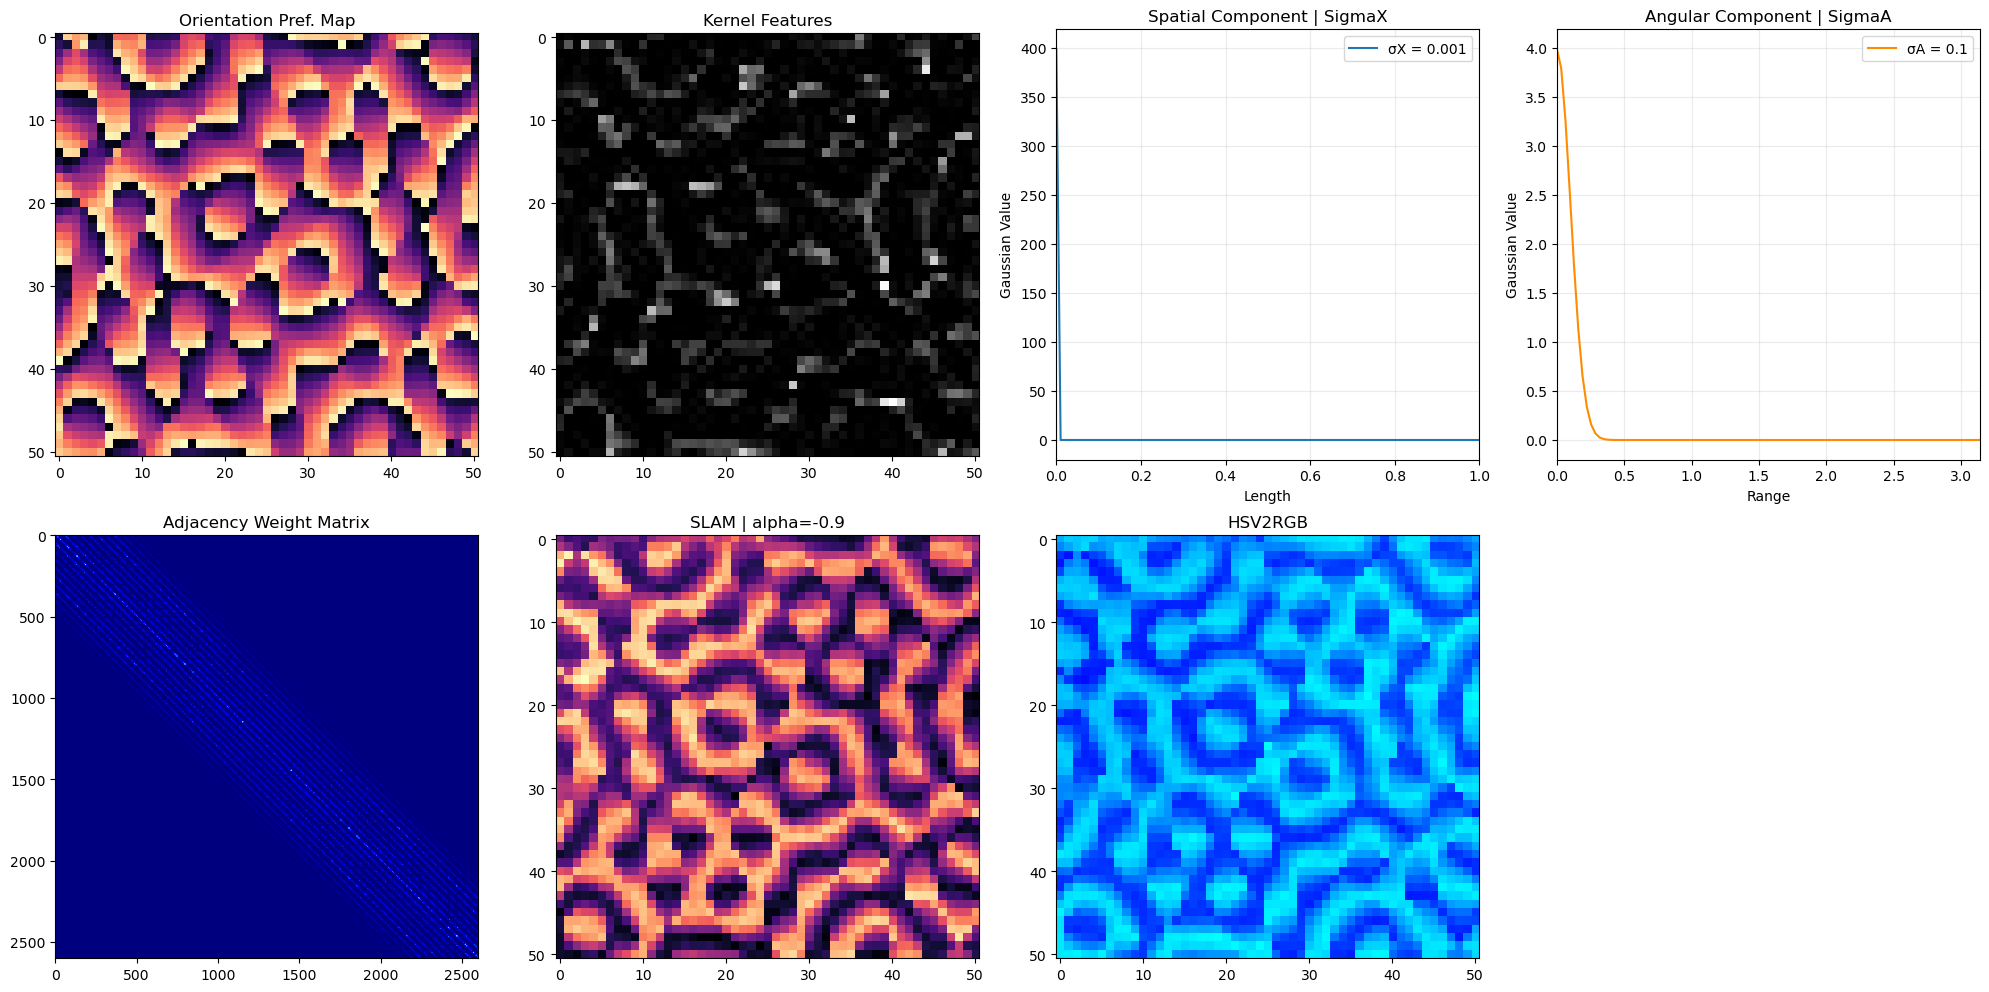

In [14]:
plt.figure(figsize=(20,10))
plt.subplot(2, 4, 1)
plt.imshow(src, 'magma')
plt.title('Orientation Pref. Map')

plt.subplot(2, 4, 2)
plt.imshow(features, 'gray')
plt.title('Kernel Features')

plt.subplot(2, 4, 3)
dist_s = np.linspace(0, 1, 100)
dist_a = np.linspace(0, np.pi, 100)
plt.plot(dist_s, libtools.gaussian(dist_s, sigmaX), label=f'σX = {sigmaX}')
plt.title('Spatial Component | SigmaX')
plt.xlabel('Length'), plt.ylabel('Gaussian Value')
plt.xlim([0, 1]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(2, 4, 4)
plt.plot(dist_a, libtools.gaussian(dist_a, sigmaA), 'darkorange', label=f'σA = {sigmaA}')
plt.title('Angular Component | SigmaA')
plt.xlabel('Range'), plt.ylabel('Gaussian Value')
plt.xlim([0, np.pi]), plt.grid(alpha=0.25), plt.legend()

plt.subplot(2, 4, 5)
plt.imshow(W, 'jet')
plt.title('Adjacency Weight Matrix')

plt.subplot(2, 4, 6)
plt.imshow(m.reshape(src.shape), 'magma')
plt.title('SLAM | alpha=' + str(alpha))

plt.subplot(2, 4, 7)
plt.imshow(hsv_map)
plt.title('HSV2RGB')
plt.tight_layout()